# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

## Group Number : 25

## Student 1 
### Name : Aditya Kunar
### ID : 5074274

## Student 2
### Name : Anwesh Marwade
### ID : 5052068

### Readme - Running our code is pretty straightforward. The comments will explicitely state what to do further down wherever human input is required. For running our code, you'll need sklearn, matplotlib, seaborn, pandas,numpy, random and re which are commonly used libraries which you will probably have installed. Lastly, the only data you'll need is what was initially provided to us all in brightspace. 


### Importing necessary libraries

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import re
import random
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

### Reading in the Data (The one provided to us in brightspace.)

In [7]:
data = "data_for_student_case.csv" #Provide the path to the data here.
df1 = pd.read_csv(data)

### Preprocessing 

In [12]:
# Apply currency conversion so that the amounts are standardized
def conv(row):
    currency_dict = {0: 0.86248, 1: 1.5911, 2: 21.2829, 3: 1.6805, 4: 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

def preprocess(df):
    # Here we simply remove the refuse class from our dataframe.
    df1 = df.copy(deep=True)
    df1 = df1.loc[~(df1['simple_journal'] == 'Refused')] #removing the unknown class.
    df1.loc[df1['simple_journal'] == 'Chargeback', 'simple_journal'] = 1 #fraud
    df1.loc[df1['simple_journal'] == 'Settled', 'simple_journal'] = 0 #Normal
    
    #Dealing with na values by filling them with default values. 
    df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
    df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
    df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'
    df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'
    
    #3-6 is made to be 3 for cvcresponsecode variable.
    df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3
    
    #Encoding the categorical variables.
    bin_enc = LabelEncoder()
    bin_enc.fit(df1['bin'].unique())
    df1['bin'] = bin_enc.transform(df1.bin)

    card_enc = LabelEncoder()
    card_enc.fit(df1['card_id'])
    df1['card_id'] = card_enc.transform(df1.card_id)

    ip_enc = LabelEncoder()
    ip_enc.fit(df1['ip_id'])
    df1['ip_id'] = ip_enc.transform(df1.ip_id)

    unique_issuer_cc = df1['issuercountrycode'].unique()
    unique_shopper_cc = df1['shoppercountrycode'].unique()
    both = np.append(unique_issuer_cc, unique_shopper_cc)
    df_countrycodes = pd.DataFrame(both)
    unique_codes = df_countrycodes[0].unique()
    enc = LabelEncoder()
    enc.fit(unique_codes)
    df1['issuercountrycode'] = enc.transform(df1.issuercountrycode)
    df1['shoppercountrycode'] = enc.transform(df1.shoppercountrycode)
    
    enc = LabelEncoder()
    enc.fit(df1['txvariantcode'])
    df1['txvariantcode'] = enc.transform(df1.txvariantcode)

    enc = LabelEncoder()
    enc.fit(df1['currencycode'])
    df1['currencycode'] = enc.transform(df1.currencycode)

    enc = LabelEncoder()
    enc.fit(df1['shopperinteraction'])
    df1['shopperinteraction'] = enc.transform(df1.shopperinteraction)

    enc = LabelEncoder()
    enc.fit(df1['accountcode'])
    df1['accountcode'] = enc.transform(df1.accountcode)

    enc = LabelEncoder()
    enc.fit(df1['cardverificationcodesupplied'])
    df1['cardverificationcodesupplied'] = enc.transform(df1.cardverificationcodesupplied)
    
    enc = LabelEncoder()
    enc.fit(df1['mail_id'])
    df1['mail_id'] = enc.transform(df1.mail_id)

    
    df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
    df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
    df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1

    #Converting creation and booking date to datestamps.
    df1['creationdate'] = pd.to_datetime(df1['creationdate'])
    df1['bookingdate'] = pd.to_datetime(df1['bookingdate'])
    
    #Obtaining the day of week and hour of transactions using date timestamps. 
    df1['date'] = df1['creationdate'].dt.date 
    df1['day_of_week'] = df1['creationdate'].dt.dayofweek
    df1['hour'] = df1['creationdate'].dt.hour
    
    #converting creation date to unix_timestap.
    dates= df1["creationdate"]
    dates=pd.DatetimeIndex(dates)
    dates=dates.astype(np.int64) // 10**9
    df1['creationdate_Unix']=dates
    
    #Standardizing amount to a single currency.
    df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)
    
    return df1
# Pre-processing the dataframe.
df1=preprocess(df1)

### Transaction Class distributions.

In [14]:
print("Number of total data points = " + str(len(df1.index)))
print("Number of fradulent transactions = " + str(len(df1.loc[df1['simple_journal'] == 1])))
print("Number of valid transactions = " + str(len(df1.loc[df1['simple_journal'] == 0])))  

Number of total data points = 237036
Number of fradulent transactions = 345
Number of valid transactions = 236691


## 1. Visualization task 

#### I) Account Code and Number of Fraud

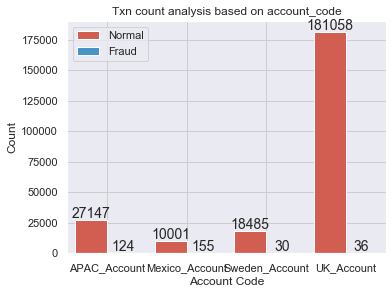

In [24]:
sns.set(rc={'figure.figsize':(5.7,4.27)})
flatui = ["#e74c3c","#3498db", "#2ecc71"]
ax = sns.countplot(x="accountcode", hue="simple_journal", data=df1, palette=flatui)
ax.set_title('Txn count analysis based on account_code')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel('Account Code')
ax.set(xticklabels=["APAC_Account","Mexico_Account","Sweden_Account","UK_Account"])
ax.legend(["Normal","Fraud"]) 
max_height = 0


for p in ax.patches:
    if p.get_height() > max_height:
        max_height = p.get_height()
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.01*max_height,'{:1d}'.format(height),
            ha="center",size=14)

#### Description-Based on this barchart, we see that there is an uneven distribution of fraud and non fraud cases from the different accounts in our dataset. We also observe that the majority of fraud cases originate from the Mexico account even though the majority transactions have occured from the UK account. 

#### II) Amount in Euros Distribution for Fraud vs Normal

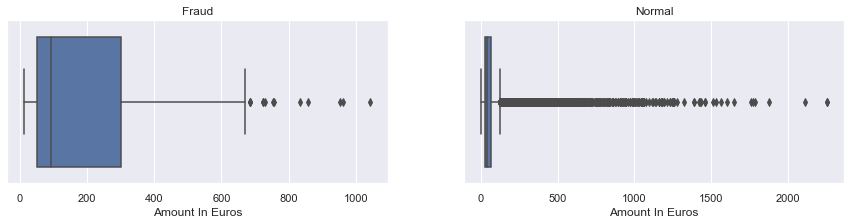

In [37]:
df_f = df1.loc[df1.simple_journal==1]
df_nf = df1.loc[df1.simple_journal==0]
nf_amt=df_nf.amount_eur.values
f_amt=df_f.amount_eur.values 
f, (ax1, ax2) = plt.subplots(1,2,figsize =(15, 3))
sns.boxplot(f_amt,ax=ax1)
ax1.set_title('Fraud')
sns.boxplot(nf_amt,ax=ax2)
ax2.set_title('Normal')
ax2.set_xlabel("Amount In Euros")
ax1.set_xlabel("Amount In Euros")
plt.show()

#### Description- We observe from the boxplots that fruadulent transactions have a wider interquartile range than non fraudulent cases with respect to amount in euros spent per transaction. And so, the distribution of amount in euros for fraud generally seems to be higher than non fraud cases as indicated by the two medians as well. But we need to keep in mind that there are many outliers for non-fraud transactions. 

#### III) Temporal relationship between Currency_code and number of fraudulent transactions

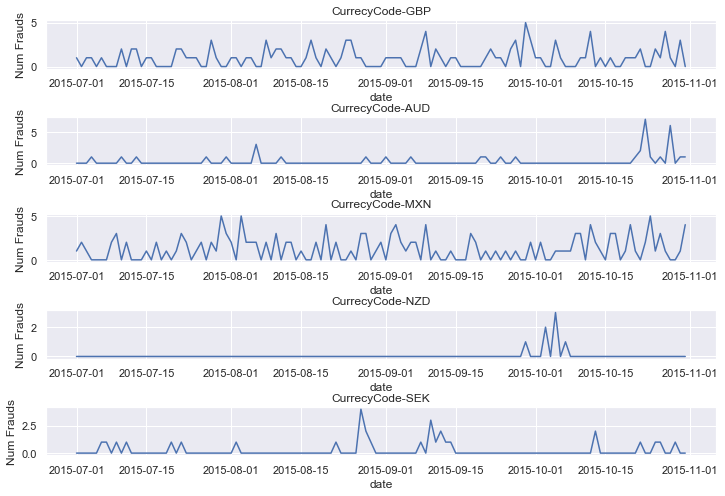

In [26]:
df_GBP=df1.loc[df1["currencycode"]==0]
df_AUD=df1.loc[df1["currencycode"]==1]
df_MXN=df1.loc[df1["currencycode"]==2]
df_NZD=df1.loc[df1["currencycode"]==3]
df_SEK=df1.loc[df1["currencycode"]==4]

df_GBP = df_GBP[['date','simple_journal']].groupby(['date']).sum()
df_AUD = df_AUD[['date','simple_journal']].groupby(['date']).sum()
df_MXN = df_MXN[['date','simple_journal']].groupby(['date']).sum()
df_NZD = df_NZD[['date','simple_journal']].groupby(['date']).sum()
df_SEK = df_SEK[['date','simple_journal']].groupby(['date']).sum()

#len(df4.loc[df4['simple_journal'] > 0])

f, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize =(12, 8))
sns.lineplot(x=df_GBP.index,y=df_GBP['simple_journal'],ax=ax1)
ax1.set(ylabel = "Num Frauds")
ax1.set_title("CurrecyCode-GBP")
sns.lineplot(x=df_AUD.index,y=df_AUD['simple_journal'],ax=ax2)
ax2.set(ylabel = "Num Frauds")
ax2.set_title("CurrecyCode-AUD")
sns.lineplot(x=df_MXN.index,y=df_MXN['simple_journal'],ax=ax3)
ax3.set(ylabel = "Num Frauds")
ax3.set_title("CurrecyCode-MXN")
sns.lineplot(x=df_NZD.index,y=df_NZD['simple_journal'],ax=ax4)
ax4.set(ylabel = "Num Frauds")
ax4.set_title("CurrecyCode-NZD")
sns.lineplot(x=df_SEK.index,y=df_SEK['simple_journal'],ax=ax5)
ax5.set(ylabel = "Num Frauds")
ax5.set_title("CurrecyCode-SEK")
plt.subplots_adjust(hspace=1)
plt.show()

#### Description- Based on the lineplots above, first we see that fraudulent transactions happen more frequently for the GBP and MXN currency codes. Secondly, we do not see any significant overlaps between dates on which most currency codes show high number of fraud cases suggesting that date is not a common denominator when it comes to fraudulent transactions.

#### IV) Difference in mean amount in euros with respect to cvcresponse code for fraud and non fraud cases.

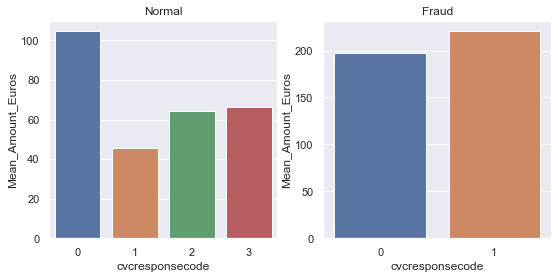

In [42]:
dff= df1.loc[df1["simple_journal"]==1]
df_nf=df1.loc[df1["simple_journal"]==0]
df5 = dff[['cvcresponsecode','amount_eur']].groupby(['cvcresponsecode']).mean()
df6 = df_nf[['cvcresponsecode','amount_eur']].groupby(['cvcresponsecode']).mean()
f, (ax1,ax2) = plt.subplots(1,2,figsize =(9, 4))
sns.barplot(x=df5.index,y=df5['amount_eur'],ax=ax2)
ax2.set(ylabel = "Mean_Amount_Euros")
ax2.set_title("Fraud")
sns.barplot(x=df6.index,y=df6['amount_eur'],ax=ax1)
ax1.set(ylabel = "Mean_Amount_Euros")
ax1.set_title("Normal")

plt.show()

#### Description- Based on the barcharts shown above we can see that for normal transactions, the mean amount in euros is higher for cvcresponsecode 0 which corresponds to unknown, however for fraud cases, the mean amount in euros is higher for cvcresponsecode 1 which corresponds to a match found. This suggests that fraudsters are good at disguising their transactions as real ones. We also note that the mean amount in terms of euros is actually also much higher for fraud cases than non fraud transactions. This can be explained with respect to the boxplots we saw previously.

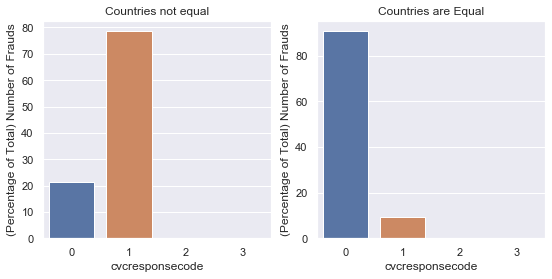

In [52]:
dff= df1.loc[df1["countries_equal"]==1]
df_nf=df1.loc[df1["countries_equal"]==0]
df5 = dff[['cvcresponsecode','simple_journal']].groupby(['cvcresponsecode']).sum()
total=df5["simple_journal"].sum()
df5["simple_journal"]=(df5["simple_journal"]/total)*100
df6 = df_nf[['cvcresponsecode','simple_journal']].groupby(['cvcresponsecode']).sum()
total=df6["simple_journal"].sum()
df6["simple_journal"]=(df6["simple_journal"]/total)*100
f, (ax1,ax2) = plt.subplots(1,2,figsize =(9, 4))
sns.barplot(x=df5.index,y=df5['simple_journal'],ax=ax2)
ax2.set(ylabel = "(Percentage of Total) Number of Frauds")
ax2.set_title("Countries are Equal")
sns.barplot(x=df6.index,y=df6['simple_journal'],ax=ax1)
ax1.set(ylabel = "(Percentage of Total) Number of Frauds")
ax1.set_title("Countries not equal")
plt.show()

#### Description- Based on the barcharts shown above we can see that for international transactions the percentage of fraud cases with a cvcresponsecode of 1 is higher whereas for local transactions, the cvcresponsecode with a value of 0 is the majority. 

#### V) Issuercountrycode and mean amount in euros for fraud vs normal transactions.

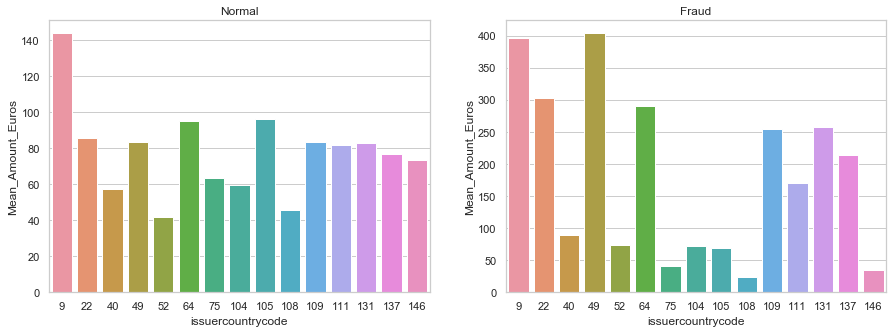

In [62]:
dff= df1.loc[df1["simple_journal"]==1]
df_nf=df1.loc[(df1["simple_journal"]==0) & (df1["issuercountrycode"].isin([9,22,40,49,52,64,75,104,105,108,109,111,131,137,146]))]
df5 = dff[['issuercountrycode','amount_eur']].groupby(['issuercountrycode']).mean()
df6 = df_nf[['issuercountrycode','amount_eur']].groupby(['issuercountrycode']).mean()
f, (ax1,ax2) = plt.subplots(1,2,figsize =(15, 5))
sns.barplot(x=df5.index,y=df5['amount_eur'],ax=ax2)
ax2.set(ylabel = "Mean_Amount_Euros")
ax2.set_title("Fraud")
sns.barplot(x=df6.index,y=df6['amount_eur'],ax=ax1)
ax1.set(ylabel = "Mean_Amount_Euros")
ax1.set_title("Normal")
plt.show()

#### Description- Based on the barchart, we first see that fraudulent transactions actually have a higher mean amount in most countries than normal transactions. We also see that the distribution of spending for different countries is not homogenous with the highest mean amount in euros for fraud occuring in issuer_country_codes 49 and 9.

#### VI) TxVariant and Mean Amount in Euros for normal and fraud cases

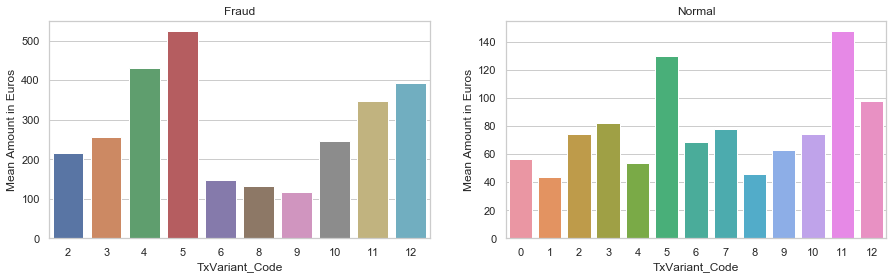

In [64]:
df2 = df1.loc[df1["simple_journal"]==1][['txvariantcode','amount_eur']].groupby(['txvariantcode']).mean()
f, (ax1,ax2) = plt.subplots(1,2,figsize =(15, 4))
sns.barplot(x=df2.index,y=df2['amount_eur'],ax=ax1)
ax1.set(ylabel = "Mean Amount in Euros")
ax1.set_xlabel('TxVariant_Code')
ax1.set_title("Fraud")
df2 = df1.loc[df1["simple_journal"]==0][['txvariantcode','amount_eur']].groupby(['txvariantcode']).mean()
sns.set(style="whitegrid")
sns.barplot(x=df2.index,y=df2['amount_eur'],ax=ax2)
ax2.set(ylabel = "Mean Amount in Euros")
ax2.set_xlabel('TxVariant_Code')
ax2.set_title("Normal")
plt.show()

#### Description- The above barchart showcases the differences in mean amount in euros for the different txvariant_codes. We similarly see a common trend that mean amount in euros is usually higher for fraudulent transactions. We also see that TxVariant_codes 5 and 4 have the highest mean amount in euros with respect to fraud. 